In [1]:
%matplotlib inline
import os
import imageio
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.utils import shuffle

In [2]:
ROOT_DIR = 'traindata_raw'
LABELS_FILE = 'labels.txt'
PIXEL_DEPTH = 255.0 
IMG_WIDTH = 32
IMG_HEIGHT = 24
N = 10000

In [3]:
lines = open(os.path.join(ROOT_DIR, LABELS_FILE)).readlines()

In [4]:
img_label_tuples = map(lambda x: x.strip().split('\t'), lines)
img_label_tuples_valid = [(img, label) for img, label in img_label_tuples
            if os.path.isfile(os.path.join(ROOT_DIR, img))]
images, labels = zip(*img_label_tuples_valid)
images, labels = shuffle(images, labels, random_state=42)

In [5]:
N = len(labels)
N

15496

In [6]:
images, labels = images[:N], labels[:N]

In [7]:
def imload(image_path):
    img = imageio.imread(image_path)
    img_gray = np.dot(img, [0.299, 0.587, 0.114])
    img_small = sp.misc.imresize(img_gray, (IMG_HEIGHT, IMG_WIDTH))
    img_norm = (img_small - PIXEL_DEPTH/2) / PIXEL_DEPTH
    return img_norm

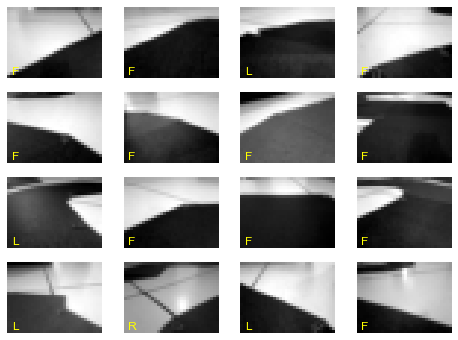

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(8,6),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = imload(os.path.join(ROOT_DIR, images[i]))
    ax.imshow(img, cmap='gray')
    ax.text(.05, .05, labels[i], transform=ax.transAxes, 
            color='yellow')

In [9]:
X = np.array(map(imload, 
                 map(lambda x: os.path.join(ROOT_DIR, x), images)))
X.shape

(15496, 24, 32)

In [10]:
unique_labels = pd.unique(labels)
idx_labels = pd.Index(unique_labels)
n_classes = len(unique_labels)
Y = pd.Series(idx_labels.get_indexer(labels), index=labels)
Y.head()

F    0
F    0
L    1
F    0
F    0
dtype: int64

In [11]:
from sklearn.decomposition import PCA

In [12]:
X_ = X.reshape(N, -1)
pca = PCA(n_components=X_.shape[1])

In [13]:
pca.fit(X_)

PCA(copy=True, iterated_power='auto', n_components=768, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
X_train = pca.transform(X_)
Y_train = Y

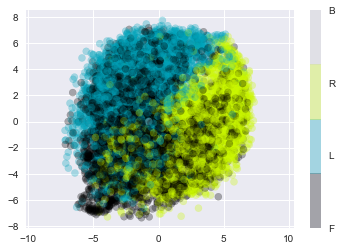

In [15]:
fig, ax = plt.figure(), plt.axes()
cax = ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=50, 
                 cmap=plt.cm.get_cmap('spectral', n_classes),
                 alpha=0.3)
cb = fig.colorbar(cax, ticks=range(n_classes))
cb.ax.set_yticklabels(unique_labels)
ax.axis('equal');

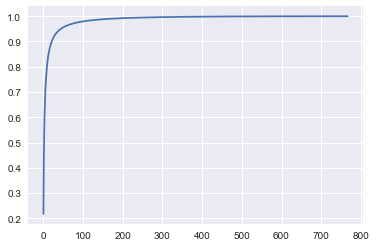

In [16]:
plt.plot(range(pca.n_components_), 
         np.cumsum(pca.explained_variance_ratio_));

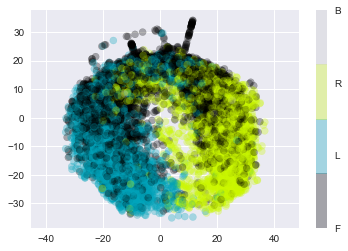

In [17]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2)
iso.fit(X.reshape(N, -1))

X_train = iso.transform(X.reshape(N, -1))
Y_train = Y

fig, ax = plt.figure(), plt.axes()
cax = ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=50, 
                 cmap=plt.cm.get_cmap('spectral', n_classes),
                 alpha=0.3)
cb = fig.colorbar(cax, ticks=range(n_classes))
cb.ax.set_yticklabels(unique_labels)
ax.axis('equal');

In [18]:
# taken from https://github.com/jakevdp/PythonDataScienceHandbook/blob/599aa0fe3f882c0001670e676e5a8d43b92c35fc/notebooks/05.10-Manifold-Learning.ipynb
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

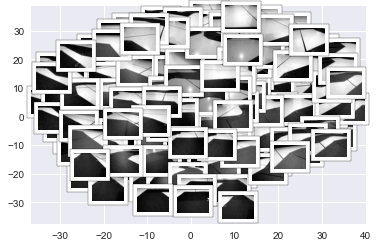

In [19]:
plot_components(X.reshape(N, -1), Isomap(n_components=2), images=X)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(N, -1), Y)

In [22]:
model = Pipeline([('pca', Isomap(n_components=50)), \
                   ('clf', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

In [23]:
model.fit(X_train, Y_train);

In [24]:
Y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix

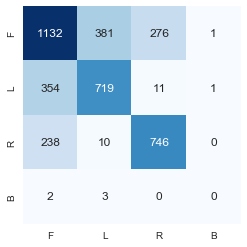

In [26]:
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat, fmt='d', annot=True, cbar=False, 
            square=True, cmap='Blues', xticklabels=unique_labels,
            yticklabels=unique_labels);

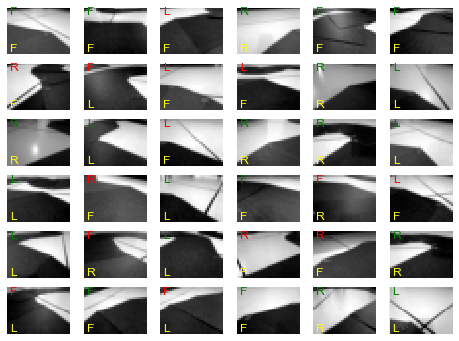

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(8,6), 
                         subplot_kw=dict(xticks=[], yticks=[]))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    ax.text(.05, .05, 
            unique_labels[Y_test[i]], color='yellow', transform=ax.transAxes)
    ax.text(.05, .85, 
            unique_labels[Y_pred[i]], color='green' if Y_test[i]==Y_pred[i] else 'red',
            transform=ax.transAxes)
plt.axis('equal');

In [28]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))

Accuracy: 0.67


In [29]:
from sklearn.externals.joblib import dump

In [30]:
dump(X, 'traindata/X.jbl')
dump(Y, 'traindata/Y.jbl')

['traindata/Y.jbl']

In [31]:
dump(model, 'models/model_pca_rf.jbl');